In [1]:
import feets
import os 
import math 
import numpy as np 
import argparse 
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.vizier import Vizier
import sys
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
fft = False
import pickle
import matplotlib.pylab as pylab
from astropy.table import Table, Column, join 


### Step 1: Reading in the light curves and extracting features 

In [2]:
def load_LC_get_feats(input_path):
    path = input_path+'/LC_files/'
    lc_with_only_zeros = []
    used_lcs = []
    filenames = []
    
    # the following at the features we'll grab using the feets package 
    Autocor_length = []
    Beyond1Std = []
    CAR_sigma = []
    CAR_mean = []
    CAR_tau =[]
    Con =[]
    Eta_e = []
    LinearTrend = []
    MaxSlope =[]
    Mean = []
    Meanvariance = []
    MedianAbsDev =[]
    MedianBRP =[]
    PairSlopeTrend =[]
    PercentAmplitude =[]
    Q31 =[]
    Rcs =[]
    Skew =[]
    SlottedA_length =[]
    SmallKurtosis =[]
    Std = []
    StetsonK_AC = []
    Amplitudes = []
    VariabilityIndex = []
    hl_ratio = []
    amp1_val = []
    amp_2_1_ratio = []
    amp_3_1_ratio = []
    phase_2_1_ratio = []
    phase_3_1_ratio = []
    files = os.listdir(path)
    for filename in files: 
        if filename.endswith('.ascii'):
            try:
                hjd, mag, emag = np.loadtxt(path + filename, unpack = True, skiprows=1)
            except: 
                print('FILE EMPTY)')
            sum_mag = np.sum(mag)
            #print(filename, sum_mag)
            if sum_mag == 0:
                lc_with_only_zeros.append(filename)
            elif sum_mag != 0:
                used_lcs.append(filename)
            clean_hjd = []
            clean_mag = []
            clean_emag = []
            for l,m,n in zip(hjd,mag, emag):
                if m != 0:
                    if m != 0:
                        clean_hjd.append(l)
                        clean_mag.append(m)
                        clean_emag.append(n)
                    elif m != float: 
                        pass 
            if len(clean_hjd) > 3:
                lc = np.array([clean_mag, clean_hjd, clean_emag])
                fs=feets.FeatureSpace(only=['Autocor_length', 'Beyond1Std', 'CAR_sigma', 'CAR_mean',
                                            'CAR_tau', 'Con', 'LinearTrend', 'MaxSlope',
                                            'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP',
                                            'PairSlopeTrend', 'PercentAmplitude', 'Q31', 'Rcs', 'Skew',
                                            'SlottedA_length', 'SmallKurtosis', 'Std',
                                            'StetsonK_AC' ])
                features, values = fs.extract(*lc)
                print(features, values)
                results = dict(zip(features,values))
                filenames.append(filename)
                Autocor_length.append(results['Autocor_length'])
                Beyond1Std.append(results['Beyond1Std'])
                CAR_sigma.append(results['CAR_sigma'])
                CAR_mean.append(results['CAR_mean'])
                CAR_tau.append(results['CAR_tau'])
                Con.append(results['Con'])
                LinearTrend.append(results['LinearTrend'])
                MaxSlope.append(results['MaxSlope'])
                Mean.append(results['Mean'])
                Meanvariance.append(results['Meanvariance'])
                MedianAbsDev.append(results['MedianAbsDev'])
                MedianBRP.append(results['MedianBRP'])
                PairSlopeTrend.append(results['PairSlopeTrend'])
                PercentAmplitude.append(results['PercentAmplitude'])
                Q31.append(results['Q31'])
                Rcs.append(results['Rcs'])
                Skew.append(results['Skew'])
                SlottedA_length.append(results['SlottedA_length'])
                SmallKurtosis.append(results['SmallKurtosis'])
                Std.append(results['Std'])
                StetsonK_AC.append(results['StetsonK_AC'])
                N = len(clean_mag)
                sorted_mag = np.sort(clean_mag)
                amp = (np.median(sorted_mag[-int(math.ceil(0.05*N)):]) - np.median(sorted_mag[0:int(math.ceil(0.05*N))])) / 2
                Amplitudes.append(amp)
                clean_mag_array = np.asarray(clean_mag)
                sigma2 = np.var(clean_mag)
                VarIndex = 1/((N-1)*sigma2)*np.sum(np.power(clean_mag_array[1:]-clean_mag_array[:-1], 2))
                VariabilityIndex.append(VarIndex)
                non_detects = []
                fft = np.fft.rfft(clean_mag)
                amps = np.sqrt(fft.real**2+fft.imag**2)
                amp1 = amps[0]
                amp1_val.append(amp1)
                amp2 = amps[1]
                amp3 = amps[2]
                amp_2_1 = amp2/amp1
                amp_3_1 = amp3/amp1 
                amp_2_1_ratio.append(amp_2_1)
                amp_3_1_ratio.append(amp_3_1)
                phases = np.arctan2(fft.imag, fft.real)
                phase1 = phases[0]
                phase2 = phases[1]
                phase3 = phases[2]
                phase_2_1 = phase2/phase1
                phase_3_1 = phase3/phase1  
                phase_2_1_ratio.append(phase_2_1)
                phase_3_1_ratio.append(phase_3_1)
            else: 
                print('Not enough data points')
    #put all into a mega table with each row representing a different light curve 
    feature_table = Table()
    feature_table['LC_name'] = filenames
    feature_table['Autocor_length'] = Autocor_length
    feature_table['Beyond1Std'] = Beyond1Std
    feature_table['CAR_sigma'] = CAR_sigma
    feature_table['CAR_mean'] = CAR_mean
    feature_table['CAR_tau'] = CAR_tau
    feature_table['Con'] = Con
    feature_table['LinearTrend'] = LinearTrend
    feature_table['MaxSlope'] = MaxSlope
    feature_table['Mean'] =Mean
    feature_table['Meanvariance'] =Meanvariance
    feature_table['MedianAbsDev'] =MedianAbsDev
    feature_table['MedianBRP'] =MedianBRP
    feature_table['PairSlopeTrend'] =PairSlopeTrend
    feature_table['PercentAmplitude'] =PercentAmplitude
    feature_table['Q31'] =Q31
    feature_table['Rcs'] =Rcs
    feature_table['Skew'] =Skew
    feature_table['SlottedA_length'] =SlottedA_length
    feature_table['SmallKurtosis'] =SmallKurtosis
    feature_table['Std'] =Std
    feature_table['StetsonK_AC'] =StetsonK_AC
    feature_table['Amplitudes'] = Amplitudes
    feature_table['amp1'] = amp1_val
    feature_table['amp_2_1_ratio'] = amp_2_1_ratio 
    feature_table['amp_3_1_ratio'] = amp_3_1_ratio
    output =input_path+'/features_set.csv'
    df = feature_table.to_pandas()
    df = df.replace(np.nan, 0)
    df.to_csv(output)
    return feature_table

In [3]:
## run the code 
input_path = 'YOUR PATH HERE'
input_path = '/Users/swebb/Downloads/ML_lightcurve_clustering-main/' 
load_LC_get_feats(input_path)

/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.12280702e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.19368740e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/op

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.22000000e+02  4.15467626e-01  1.17667375e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.94066711e-01             inf
  5.88336874e+04  1.59786859e-06  8.18815000e-02  1.90647482e-01
  9.66666667e-01  2.75805417e-06  1.63447250e-01  4.34882434e-01
  3.29451879e-03             nan -1.21192043e+00  9.40085009e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.03169014e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.36008074e-01  2.43222000e+05
  5.88336888e+04  1.58922163e-06  8.10295000e-02  1.98943662e-01
  9.66666667e-01  2.75805417e-06  1.61779000e-01  4.33242183e-01
 -1.15181956e-03             nan -1.19403865e+00  9.34997710e-02
             nan]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.22807018e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -6.92059852e-01             inf
  5.88336882e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.03508772e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.13297050e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.22807018e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -9.76935954e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=d

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.04929577e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.86032198e-01             inf
  5.88336886e+04  1.59337103e-06  8.10295000e-02  1.98943662e-01
  9.66666667e-01  2.75805417e-06  1.61779000e-01  4.33109238e-01
 -5.54018958e-03             nan -1.19414677e+00  9.37438948e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/op

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.22000000e+02  4.12500000e-01  1.17667380e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.23572937e-01             inf
  5.88336898e+04  1.59349440e-06  8.10295000e-02  2.01785714e-01
  9.66666667e-01  2.79674788e-06  1.61770750e-01  4.32513494e-01
 -2.99680559e-02             nan -1.18686295e+00  9.37511555e-02
             nan]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.20000000e+02  4.11657559e-01  1.17667379e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.32437817e-01  2.77338000e+05
  5.88336895e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=d

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.07732865e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -5.06791796e-01             inf
  5.88336883e+04  1.59488473e-06  8.14890000e-02  1.96836555e-01
  9.66666667e-01  2.75325251e-06  1.62622000e-01  4.33671001e-01
  1.14062408e-03             nan -1.20042521e+00  9.38329508e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.01754386e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.49708161e-02  1.49363000e+05
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.03508772e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  9.53345905e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.20774648e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  4.08919309e-02  2.64286000e+05
  5.88336886e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.21052632e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.67060589e+00  4.38760000e+04
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.03000000e+02  4.17355372e-01  1.17667393e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -5.17954248e-02  1.50284500e+05
  5.88336963e+04  1.55792482e-06  7.61815000e-02  2.31404959e-01
  9.66666667e-01  2.92962203e-06  1.52798500e-01  4.27139260e-01
 -8.25497006e-02  1.00000000e+00 -1.12034803e+00  9.16584757e-02
  8.46938315e-01]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.00702988e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.48655575e-01             inf
  5.88336881e+04  1.59386763e-06  8.14740000e-02  1.98594025e-01
  9.66666667e-01  2.76236296e-06  1.62622000e-01  4.33254262e-01
  4.90077104e-03             nan -1.19671692e+00  9.37731107e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.11000000e+02  4.10714286e-01  1.17667399e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -8.71292959e-02             inf
  5.88336993e+04  1.50617530e-06  7.59115000e-02  1.90476190e-01
  9.66666667e-01  2.72337980e-06  1.51532250e-01  4.34393127e-01
 -2.29807668e-02  1.00000000e+00 -1.17220216e+00  8.86138644e-02
  1.00000000e+00]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.10526316e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.35204264e-01  2.63104000e+05
  5.88336882e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 9.60000000e+01  4.23076923e-01  1.17667402e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.07089615e+00  2.71890000e+04
  5.88337011e+04  1.61008936e-06  8.04370000e-02  1.92307692e-01
  9.66666667e-01  3.05569735e-06  1.61443000e-01  4.32904082e-01
 -1.83040679e-01             nan -1.18534713e+00  9.47275163e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.23000000e+02  4.06749556e-01  1.17667379e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.18487861e-01  1.24707000e+05
  5.88336897e+04  1.58700004e-06  8.05740000e-02  2.00710480e-01
  9.66666667e-01  2.78214744e-06  1.60916500e-01  4.32737972e-01
 -1.62818821e-02             nan -1.18706500e+00  9.33690681e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.23000000e+02  4.10301954e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  2.31088936e-01  1.24707000e+05
  5.88336889e+04  1.59811958e-06  8.17030000e-02  1.97158082e-01
  9.66666667e-01  2.77259511e-06  1.63195500e-01  4.33674889e-01
 -1.24282764e-02             nan -1.20253223e+00  9.40232700e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.11247803e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -5.14125827e-01             inf
  5.88336884e+04  1.59415877e-06  8.14890000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62622000e-01  4.33291460e-01
 -1.65446606e-03             nan -1.19760112e+00  9.37902402e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/pha

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.20035149e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.77587823e-01             inf
  5.88336883e+04  1.59488229e-06  8.14890000e-02  1.96836555e-01
  9.66666667e-01  2.75325251e-06  1.62622000e-01  4.33661100e-01
  1.07769273e-03  1.00000000e+00 -1.20041424e+00  9.38328075e-02
  1.00000000e+00]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.14000000e+02  4.19047619e-01  1.17667385e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.61175731e-01  1.91647000e+05
  5.88336925e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-pa

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.04000000e+02  4.23799582e-01  1.17667396e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  4.79383671e-01  1.71080000e+04
  5.88336981e+04  1.60470277e-06  8.06530000e-02  2.00417537e-01
  9.66666667e-01  3.02185631e-06  1.60916500e-01  4.32564817e-01
 -1.50551102e-01  1.00000000e+00 -1.17488027e+00  9.44105983e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.06690141e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  3.09184019e-01             inf
  5.88336883e+04  1.59225636e-06  8.10300000e-02  1.98943662e-01
  9.66666667e-01  2.75752728e-06  1.61778250e-01  4.33101508e-01
  1.90337892e-03             nan -1.19275253e+00  9.36783142e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.21052632e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.97815977e+00             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.08771930e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  3.42957477e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.22807018e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.30735118e+00  6.26919999e+04
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.10526316e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -8.72096338e-02             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.22807018e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.19481983e-01  8.26000000e+03
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03  1.00000000e+00 -1.19727335e+00  9.37509679e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/op

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.16666667e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -6.21022533e-01             inf
  5.88336882e+04  1.60173895e-06  8.21585000e-02  1.89716312e-01
  9.66666667e-01  2.75805417e-06  1.64027000e-01  4.35065900e-01
  2.04561018e-03             nan -1.21544744e+00  9.42362099e-02
             nan]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.22807018e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.34304082e-01  3.96950000e+04
  5.88336882e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=d

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.19298246e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.54568712e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 9.50000000e+01  4.23162584e-01  1.17667413e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -8.69022918e-02             inf
  5.88337064e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.05263158e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.92508798e-01  2.22646000e+05
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, 

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.23550088e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.88507510e-01             inf
  5.88336883e+04  1.59450030e-06  8.14890000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62622000e-01  4.33369539e-01
 -1.03268930e-03             nan -1.19881226e+00  9.38103335e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.07017544e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.03561353e+00             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.16520211e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.60200024e-01             inf
  5.88336882e+04  1.59488841e-06  8.14890000e-02  1.96836555e-01
  9.66666667e-01  2.75325251e-06  1.62622000e-01  4.33691296e-01
  1.26778284e-03  1.00000000e+00 -1.20044174e+00  9.38331674e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.10526316e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.54440818e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.07732865e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.15172185e+00  1.23207000e+05
  5.88336882e+04  1.59488765e-06  8.14890000e-02  1.96836555e-01
  9.66666667e-01  2.75325251e-06  1.62622000e-01  4.33686230e-01
  1.23627090e-03             nan -1.20043834e+00  9.38331228e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.03508772e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.59488838e-01             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.14762742e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  4.88911215e-01             inf
  5.88336880e+04  1.59266143e-06  8.11400000e-02  1.98594025e-01
  9.66666667e-01  2.76236296e-06  1.62060000e-01  4.33224382e-01
  4.61897659e-03             nan -1.19475999e+00  9.37021459e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.23000000e+02  4.14285714e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  4.23278436e-01  1.63668000e+05
  5.88336892e+04  1.59443714e-06  8.13110000e-02  1.96428571e-01
  9.66666667e-01  2.77737128e-06  1.62342250e-01  4.33816331e-01
 -7.94130676e-03             nan -1.20014759e+00  9.38066193e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.11971831e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  6.40002273e-01             inf
  5.88336884e+04  1.59396160e-06  8.13110000e-02  1.97183099e-01
  9.66666667e-01  2.75752728e-06  1.62342000e-01  4.33515422e-01
 -9.57537223e-04             nan -1.19785966e+00  9.37786400e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=d

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.12280702e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.35885544e-02             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
  1.00000000e+00]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.11247803e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  7.84885123e-01             inf
  5.88336880e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.11247803e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.91974427e-01             inf
  5.88336882e+04  1.59472924e-06  8.14740000e-02  1.96836555e-01
  9.66666667e-01  2.76236296e-06  1.62622000e-01  4.33472928e-01
  3.21065999e-03             nan -1.19973442e+00  9.38238031e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.20494700e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.87478988e-01             inf
  5.88336887e+04  1.59554775e-06  8.16000000e-02  1.97879859e-01
  9.66666667e-01  2.76772547e-06  1.62908000e-01  4.33450238e-01
 -8.34701706e-03             nan -1.19858697e+00  9.38719597e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.04929577e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.60176544e-01             inf
  5.88336883e+04  1.59516885e-06  8.15880000e-02  1.97183099e-01
  9.66666667e-01  2.75752728e-06  1.62902750e-01  4.33390900e-01
 -1.92077937e-04             nan -1.19938753e+00  9.38496667e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, 

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.10526316e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.18575559e-02             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.23000000e+02  4.15929204e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.22520613e-02  1.62483000e+05
  5.88336892e+04  1.59074473e-06  8.05640000e-02  2.00000000e-01
  9.66666667e-01  2.77259511e-06  1.60915000e-01  4.32755511e-01
 -1.47178393e-02  1.00000000e+00 -1.18662306e+00  9.35893810e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/op

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.07732865e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.52015505e-02             inf
  5.88336885e+04  1.59079499e-06  8.11330000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62059000e-01  4.33341499e-01
  1.28670477e-03             nan -1.19701465e+00  9.35923372e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.05263158e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  6.11333255e-02             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.15492958e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.46380995e+00  5.46499999e+04
  5.88336887e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.11247803e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.74402820e-01             inf
  5.88336884e+04  1.59350162e-06  8.11330000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62059000e-01  4.33230910e-01
 -2.02126102e-03             nan -1.19586432e+00  9.37515776e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.21052632e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  1.12145859e+00             inf
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.04217926e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -2.53825639e-01  1.30126000e+05
  5.88336882e+04  1.59456865e-06  8.14740000e-02  1.98594025e-01
  9.66666667e-01  2.76236296e-06  1.62622000e-01  4.33393542e-01
  3.82358065e-03             nan -1.19906973e+00  9.38143549e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.10934744e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.17392811e-01             inf
  5.88336888e+04  1.59270213e-06  8.09280000e-02  1.99294533e-01
  9.66666667e-01  2.76285582e-06  1.61489500e-01  4.32980657e-01
 -8.85040368e-03             nan -1.19164240e+00  9.37045415e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.22807018e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.16656076e-01  5.75062500e+03
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03  1.00000000e+00 -1.19727335e+00  9.37509679e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.18277680e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.01178243e+00  2.36008000e+05
  5.88336884e+04  1.59285054e-06  8.11330000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62059000e-01  4.33223022e-01
 -1.77879523e-03             nan -1.19491719e+00  9.37132724e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/op

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.07732865e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -4.00682367e-01             inf
  5.88336885e+04  1.59228668e-06  8.11330000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62059000e-01  4.33239143e-01
 -1.23633034e-03             nan -1.19472156e+00  9.36800987e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.14462081e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.94209428e-01             inf
  5.88336888e+04  1.59253250e-06  8.09280000e-02  1.99294533e-01
  9.66666667e-01  2.76285582e-06  1.61489500e-01  4.32978729e-01
 -8.78538877e-03  1.00000000e+00 -1.19139714e+00  9.36945617e-02
  1.00000000e+00]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 4.50000000e+01  4.22330097e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.32404534e-01  1.36053704e+03
  5.88336878e+04  1.58403331e-06  8.42595000e-02  2.08737864e-01
  9.66666667e-01  2.75321851e-06  1.67549500e-01  4.29111478e-01
 -1.02499100e-02  1.00000000e+00 -1.13654373e+00  9.31945213e-02
  1.00000000e+00]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.05975395e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -3.18941263e-04             inf
  5.88336884e

/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.04929577e-01  1.17667378e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  2.65075523e-01  2.15543000e+05
  5.88336888e+04  1.58839111e-06  8.10295000e-02  1.98943662e-01
  9.66666667e-01  2.75805417e-06  1.61779000e-01  4.33309330e-01
  4.64571106e-04             nan -1.19593081e+00  9.34509085e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.07017544e-01  1.17667376e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  7.80917003e-01  2.29489231e+04
  5.88336882e+04  1.59349126e-06  8.13110000e-02  1.98245614e-01
  9.66666667e-01  2.75752728e-06  1.62340750e-01  4.33347058e-01
  1.49098131e-03             nan -1.19727335e+00  9.37509679e-02
             nan]


/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=d

['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  4.03169014e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -1.66867664e-01             inf
  5.88336884e+04  1.59564317e-06  8.15955000e-02  1.97183099e-01
  9.66666667e-01  2.75805417e-06  1.62902750e-01  4.33580790e-01
 -2.20670412e-03             nan -1.20102521e+00  9.38775732e-02
             nan]


/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  phase_2_1 = phase2/phase1
/var/folders/rw/x2cf5q4d4pb3gjtnt9b1qkbx3lm9jr/T/ipykernel_73733/1328582039.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  phase_3_1 = phase3/phase1
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.24000000e+02  3.97188049e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00  5.76745926e-01             inf
  5.88336884e+04  1.59285054e-06  8.11330000e-02  1.98594025e-01
  9.66666667e-01  2.75325251e-06  1.62059000e-01  4.33223022e-01
 -1.77879523e-03  1.00000000e+00 -1.19491719e+00  9.37132724e-02
  1.00000000e+00]
['Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'Con'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'PairSlopeTrend' 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StetsonK_AC'] [ 1.25000000e+02  4.14762742e-01  1.17667377e+05  1.00000000e+01
  5.00000000e-01  0.00000000e+00 -5.41232132e-01             inf
  5.88336883e

/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/swebb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/swebb/op

LC_name,Autocor_length,Beyond1Std,CAR_sigma,CAR_mean,CAR_tau,Con,LinearTrend,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK_AC,Amplitudes,amp1,amp_2_1_ratio,amp_3_1_ratio
str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
exampledata_66.ascii,125.0,0.41228070175438597,10.0,117667.37648286665,0.5,0.0,-0.21936874011488844,inf,58833.68824143332,1.5934912576761697e-06,0.08131099999809521,0.19824561403508772,0.9666666666666667,2.7575272837000535e-06,0.1623407499937457,0.43334705836919707,0.001490981310478565,nan,-1.1972733490992156,0.09375096786956927,nan,0.06138900000000014,13868.276779,8.675300070789861e-05,0.0001690344465492537
exampledata_23.ascii,122.0,0.4154676258992806,10.0,117667.37474147123,0.5,0.0,-0.2940667108485949,inf,58833.68737073561,1.5978685872744373e-06,0.08188149999841698,0.1906474820143885,0.9666666666666667,2.758054166055268e-06,0.16344725000089966,0.43488243438417573,0.003294518786411605,nan,-1.211920428025582,0.09400850092322321,nan,0.04709825000000123,13308.103790000001,9.282210645632661e-05,9.469947770980368e-05
exampledata_42.ascii,124.0,0.40316901408450706,10.0,117667.37752905987,0.5,0.0,-0.4360080736630924,243221.9997473097,58833.688764529936,1.589221634448039e-06,0.08102950000102283,0.198943661971831,0.9666666666666667,2.758054166055268e-06,0.1617790000018431,0.4332421828408995,-0.0011518195624547103,nan,-1.1940386527878226,0.0934997710189735,nan,0.07902449999999916,14101.917163,0.00017990450527262774,0.00023227349760485605
exampledata_3.ascii,125.0,0.42280701754385963,10.0,117667.37648286665,0.5,0.0,-0.6920598524705819,inf,58833.68824143332,1.5934912576761697e-06,0.08131099999809521,0.19824561403508772,0.9666666666666667,2.7575272837000535e-06,0.1623407499937457,0.43334705836919707,0.001490981310478565,nan,-1.1972733490992156,0.09375096786956927,nan,0.026773500000000894,11850.253225,0.00010963880755907312,0.00011952601306789401
exampledata_38.ascii,125.0,0.40350877192982454,10.0,117667.37648286665,0.5,0.0,-0.41329704983616505,inf,58833.68824143332,1.5934912576761697e-06,0.08131099999809521,0.19824561403508772,0.9666666666666667,2.7575272837000535e-06,0.1623407499937457,0.43334705836919707,0.001490981310478565,nan,-1.1972733490992156,0.09375096786956927,nan,0.08790549999999975,14152.090897,0.0002728813600968077,0.00010790671953903722
exampledata_1.ascii,125.0,0.42280701754385963,10.0,117667.37648286665,0.5,0.0,-0.9769359541868282,inf,58833.68824143332,1.5934912576761697e-06,0.08131099999809521,0.19824561403508772,0.9666666666666667,2.7575272837000535e-06,0.1623407499937457,0.43334705836919707,0.001490981310478565,nan,-1.1972733490992156,0.09375096786956927,nan,0.040118999999998906,12056.132897,0.00013173473334257874,0.00013013482516977248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
exampledata_10.ascii,45.0,0.4223300970873786,10.0,117667.37552940777,0.5,0.0,-0.3324045338247155,1360.5370369851669,58833.687764703885,1.5840333126000162e-06,0.08425950000309967,0.2087378640776699,0.9666666666666667,2.7532185145521475e-06,0.16754950000176905,0.42911147831198737,-0.010249909971720478,1.0,-1.1365437336219446,0.09319452132239894,1.0,0.23412450000000007,4959.923825,0.0045266892595098715,0.0006657157145283143
exampledata_55.ascii,124.0,0.40597539543058,10.0,117667.37688034447,0.5,0.0,-0.0003189412628760033,inf,58833.688440172235,1.5928505402474623e-06,0.08113299999968149,0.19859402460456943,0.9666666666666667,2.7532525085992187e-06,0.16205900000204565,0.4332230219650395,-0.001778795232460149,1.0,-1.1949171889075032,0.09371327241667922,1.0,0.0726129999999987,14083.565364999999,0.00010446967470739269,5.783762049792297e-05


# Step 3: Cluster the features 

In [4]:
## Read in the feature file and turn into Data frame
filename = 'features_set.csv'
filepath = 'YOUR PATH HERE'
filepath = "/Users/swebb/Downloads/ML_lightcurve_clustering-main/"+filename
df = pd.read_csv(filepath, delimiter=',')
df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)
print(df)

    Unnamed: 0               LC_name  Autocor_length  Beyond1Std  CAR_sigma  \
0            0  exampledata_66.ascii           125.0    0.412281       10.0   
1            1  exampledata_23.ascii           122.0    0.415468       10.0   
2            2  exampledata_42.ascii           124.0    0.403169       10.0   
3            3   exampledata_3.ascii           125.0    0.422807       10.0   
4            4  exampledata_38.ascii           125.0    0.403509       10.0   
..         ...                   ...             ...         ...        ...   
65          65  exampledata_68.ascii           124.0    0.404930       10.0   
66          66  exampledata_34.ascii           125.0    0.407018       10.0   
67          67  exampledata_36.ascii           124.0    0.403169       10.0   
68          68  exampledata_12.ascii           124.0    0.397188       10.0   
69          69  exampledata_57.ascii           125.0    0.414763       10.0   

         CAR_mean  CAR_tau  Con  LinearTrend      M

In [5]:
# Seperate into clean lists

LC_name = []
Autocor_length = []
Beyond1Std = []
CAR_sigma = []
CAR_mean= []
CAR_tau= []
Con= []
LinearTrend= []
MaxSlope= []
Mean= []
Meanvariance= []
MedianAbsDev= []
MedianBRP= []
PairSlopeTrend= []
PercentAmplitude= []
Q31= []
Rcs= []
Skew= []
SlottedA_length= []
SmallKurtosis= []
Std= []
StetsonK_AC= []
Amplitudes= []
Amp1= []
Amp_2_1_ratio= []
Amp_3_1_ratio = []
for index, row in df.iterrows():
    LC_name.append(row.LC_name)
    Autocor_length.append(row.Autocor_length)
    Beyond1Std.append(row.Beyond1Std)
    CAR_sigma.append(row.CAR_sigma)
    CAR_mean.append(row.CAR_mean)
    CAR_tau.append(row.CAR_tau)
    Con.append(row.Con)
    LinearTrend.append(row.LinearTrend)
    MaxSlope.append(row.MaxSlope)
    Mean.append(row.Mean)
    Meanvariance.append(row.Meanvariance)
    MedianAbsDev.append(row.MedianAbsDev)
    MedianBRP.append(row.MedianBRP)
    PairSlopeTrend.append(row.PairSlopeTrend)
    PercentAmplitude.append(row.PercentAmplitude)
    Q31.append(row.Q31)
    Rcs.append(row.Rcs)
    Skew.append(row.Skew)
    SlottedA_length.append(row.SlottedA_length)
    SmallKurtosis.append(row.SmallKurtosis)
    Std.append(row.Std)
    StetsonK_AC.append(row.StetsonK_AC)
    Amplitudes.append(row.Amplitudes)
    Amp1.append(row.amp1)
    Amp_2_1_ratio.append(row.amp_2_1_ratio)
    Amp_3_1_ratio.append(row.amp_3_1_ratio)
    
    
#Beyond1Std, CAR_sigma, CAR_mean, CAR_tau, Con, LinearTrend, MaxSlope, Mean, Meanvariance, MedianAbsDev, MedianBRP, PairSlopeTrend, PercentAmplitude, Q31, Rcs, Skew, SlottedA_length, SmallKurtosis, Std, StetsonK_AC, Amplitudes, Amp1, Amp_2_1_ratio, Amp_3_1_ratio = np.loadtxt(filepath, unpack = True, skiprows=1)

In [6]:
# create dictionary for all the wanted features (change up for different requirements,
# you dont' have to use all the features :) 
dict = {'Filename': LC_name, 'Autocor_length': Autocor_length, 
        'Beyond1Std' : Beyond1Std, 'CAR_sigma': CAR_sigma, 
        'CAR_mean': CAR_mean, 'CAR_tau':CAR_tau, 'Con':Con, 
        'LinearTrend': LinearTrend, 
        'MaxSlope':MaxSlope, 'Mean' : Mean, 
        'Meanvariance': Meanvariance, 'MedianAbsDev': MedianAbsDev,
        'MedianBRP' : MedianBRP, 'PairSlopeTrend' : PairSlopeTrend, 
        'PercentAmplitude' : PercentAmplitude, 'Q31':Q31, 'Rcs':Rcs,
        'Skew':Skew, 'SlottedA_length' :SlottedA_length,
        'SmallKurtosis':SmallKurtosis, 'Std':Std, 
        'StetsonK_AC':StetsonK_AC, 'Amplitudes':Amplitudes,
        'Amp1': Amp1, 'Amp_2_1_ratio': Amp_2_1_ratio, 'Amp_3_1_ratio': Amp_3_1_ratio}

In [7]:
#Put dictionary into a pandas datadframe with no NaNs or Infs  #
dframe = pd.DataFrame(dict)
dframe.replace('inf', 0)
dframe = dframe.replace(np.nan, 0)
print(len(dframe))
print(dframe)

70
                Filename  Autocor_length  Beyond1Std  CAR_sigma  \
0   exampledata_66.ascii           125.0    0.412281       10.0   
1   exampledata_23.ascii           122.0    0.415468       10.0   
2   exampledata_42.ascii           124.0    0.403169       10.0   
3    exampledata_3.ascii           125.0    0.422807       10.0   
4   exampledata_38.ascii           125.0    0.403509       10.0   
..                   ...             ...         ...        ...   
65  exampledata_68.ascii           124.0    0.404930       10.0   
66  exampledata_34.ascii           125.0    0.407018       10.0   
67  exampledata_36.ascii           124.0    0.403169       10.0   
68  exampledata_12.ascii           124.0    0.397188       10.0   
69  exampledata_57.ascii           125.0    0.414763       10.0   

         CAR_mean  CAR_tau  Con  LinearTrend      MaxSlope          Mean  ...  \
0   117667.376483      0.5  0.0    -0.219369           inf  58833.688241  ...   
1   117667.374741      0.5  0.

In [8]:
#Define what features to use in the clustering, don't cluster on the targert/ID names! # 
features = ['Autocor_length', 'Beyond1Std', 'CAR_sigma', 'CAR_mean', 
            'CAR_tau', 'Con', 'LinearTrend', 
            'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 
            'PairSlopeTrend', 'Q31', 'Rcs', 'Skew', 'SlottedA_length',
            'SmallKurtosis', 'Std', 'StetsonK_AC', 'Amplitudes',
            'Amp1', 'Amp_2_1_ratio', 'Amp_3_1_ratio']

In [9]:
## Separating out the features:
x = dframe.loc[:, features].values
## Separating out the LC names:
y = dframe.loc[:,['Filename']].values
# Standardise the features
x = StandardScaler().fit_transform(x)

## run quick PCA 

In [10]:
## Simple 2D component breakdown for PCA. Don't need to do this but can be helpful to see ##
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns =['PC1', 'PC2'])
finalDf = pd.concat([principalDf, dframe[['Filename']]], axis =1)

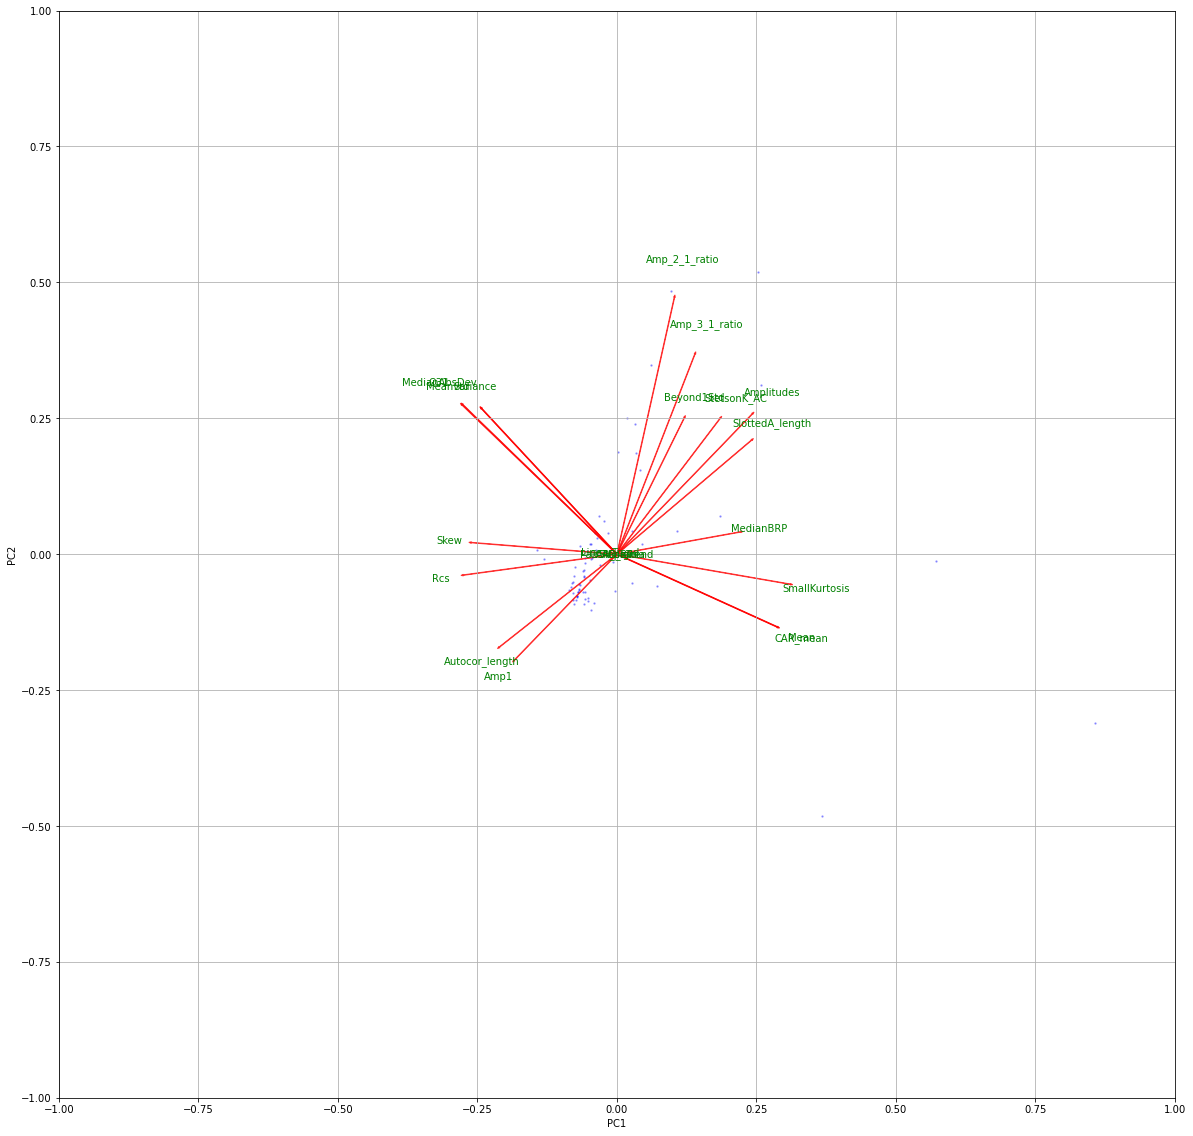

['Autocor_length', 'Beyond1Std', 'CAR_sigma', 'CAR_mean', 'CAR_tau', 'Con', 'LinearTrend', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend', 'Q31', 'Rcs', 'Skew', 'SlottedA_length', 'SmallKurtosis', 'Std', 'StetsonK_AC', 'Amplitudes', 'Amp1', 'Amp_2_1_ratio', 'Amp_3_1_ratio']


In [11]:
def myplot(score, coeff, labels=None):
        xs = score[:,0]
        ys = score[:,1]
        n = coeff.shape[0]
        scalex = 1.0/(xs.max() - xs.min())
        scaley = 1.0/(ys.max() - ys.min())
        plt.scatter(xs*scalex, ys*scaley, c ='b' , alpha =0.3, s =2)
        for i in range(n):
                plt.arrow(0,0, coeff[i,0], coeff[i,1], color = 'r', alpha =0.7)
                if labels is None:
                        plt.text(coeff[i,0]*1.15, coeff[i,1] *1.15, "Var"+str(i+1), color="hotpink", ha = 'center', va = 'center')
                else:
                        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
fig = plt.figure(figsize=(20,20))
plt.xlim(-1,1)
plt.ylim(-1, 1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]), labels=features)
plt.show()
print(features)

## run quick TNSE and HDBSCAN on the featues  

In [12]:
tsne =TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(x)
clusterer = hdbscan.HDBSCAN(metric='euclidean')
hdbscan_result = clusterer.fit(x)
hdbscan_result.labels_
hdbscan_result.labels_.max()
labels = hdbscan_result.labels_
n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
print(n_clusters_)

2


HDBSCAN()


<AxesSubplot:ylabel='$\\lambda$ value'>

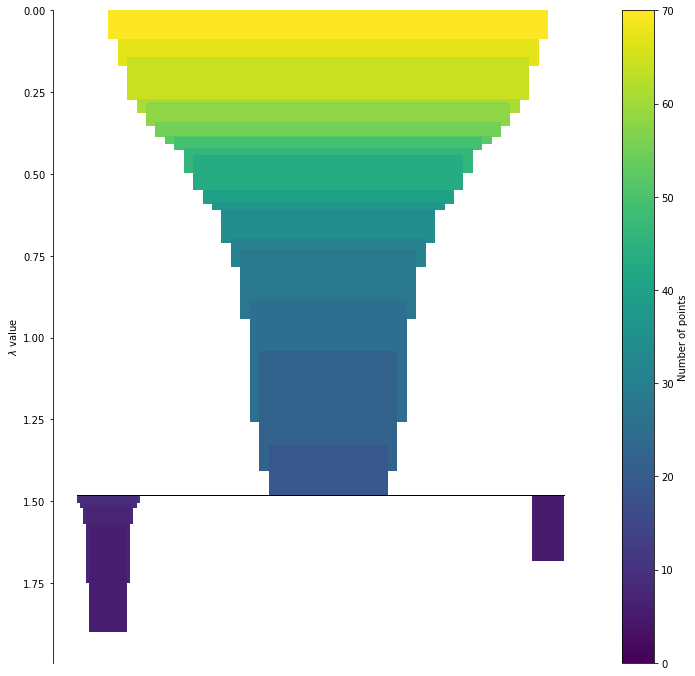

In [13]:
print(hdbscan_result)
fig = plt.figure(figsize=(12,12))
clusterer.condensed_tree_.plot()

Text(0, 0.5, 'Number of Light Curves')

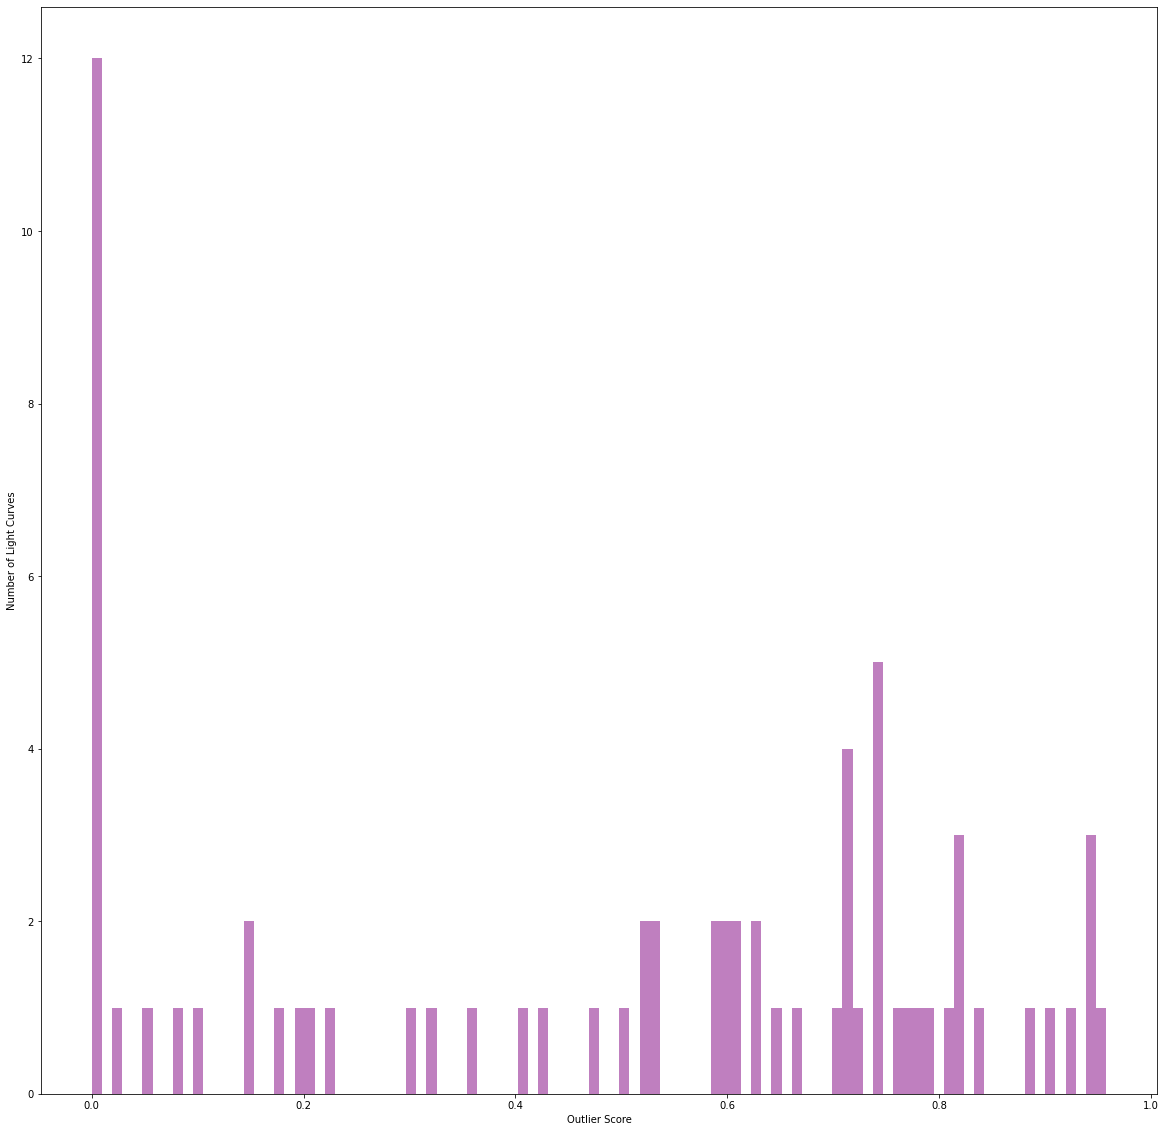

In [14]:
## clusterer.outlier_scores_
fig = plt.figure(figsize=(20,20))
plt.hist(clusterer.outlier_scores_, bins=100, color='purple', alpha=0.5)
plt.xlabel('Outlier Score')
plt.ylabel('Number of Light Curves')

In [15]:
tsne = tsne_results 
filenames = np.array(y)
cluster_score = np.array(hdbscan_result.labels_)
cluster_score_reshape = cluster_score.reshape(len(x),1)
tsne_filenames = np.append(filenames, tsne, axis=1)
tsne_filenames_clusters = np.append(tsne_filenames,cluster_score_reshape, axis=1 )


In [16]:
def get_cmap(n, name='nipy_spectral'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

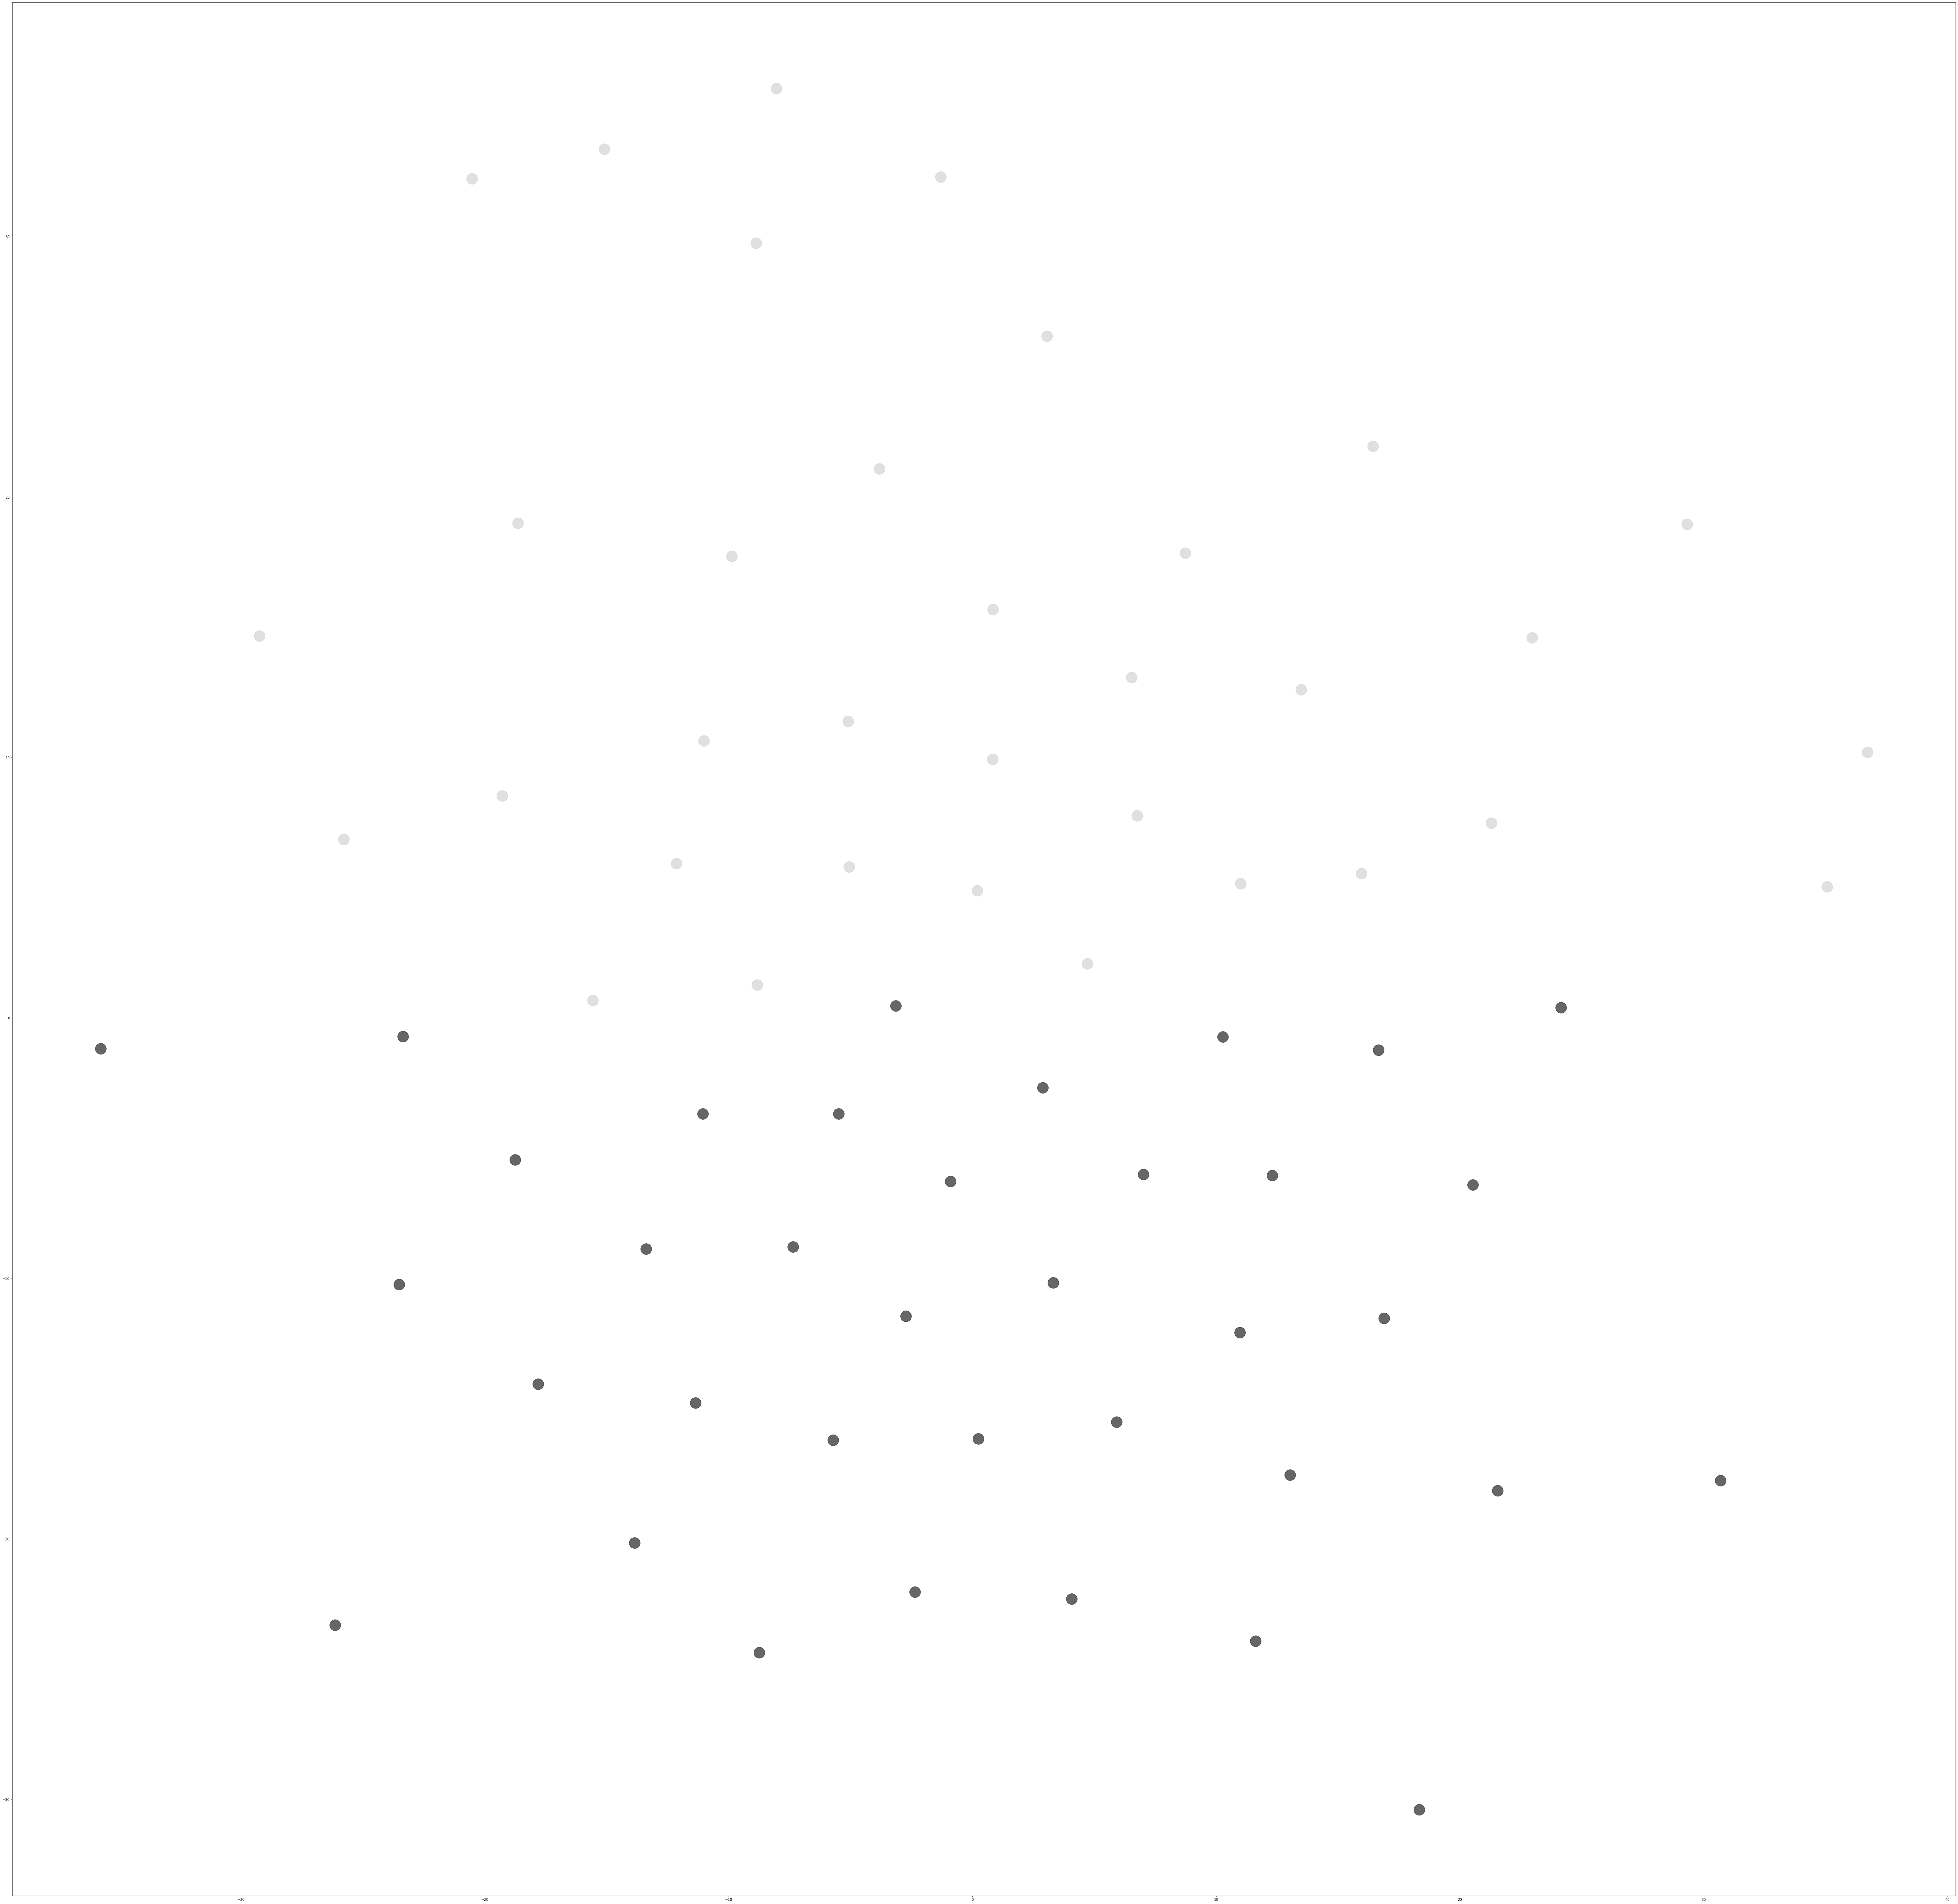

In [17]:
cmap = get_cmap(n_clusters_)
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111)

params = {'legend.fontsize': 'x-large',
          'legend.fontsize': 100,
          'legend.handlelength': 2,
          'figure.figsize': (100, 100),
         'axes.labelsize': '100',
         'axes.titlesize':'100',
         'xtick.labelsize':'100',
         'ytick.labelsize':'100'}
pylab.rcParams.update(params)

for cluster in np.unique(tsne_filenames_clusters[:,n_clusters_]):
    #msk = np.where(tsne_filenames_clusters[:,4]==cluster)[0]
    msk = np.where(tsne_filenames_clusters[:,n_clusters_]==cluster)[0]
    xx = tsne_filenames_clusters[msk,1]
    yy = tsne_filenames_clusters[msk,2]
    ax.scatter(xx, yy, alpha=0.6, label=cluster, c=cmap(cluster), s=1000)

In [18]:
# save clusters for looking through in program such as astronomally using isolation forest to rank (great for big data sets)
d = {}
for cluster in np.unique(tsne_filenames_clusters[:,n_clusters_]):
    #print(cluster)
    msk = np.where(tsne_filenames_clusters[:,3]==cluster)[0]
    #print(tsne_filenames_clusters[:,0])
    d["cluster{0}".format(cluster)] = tsne_filenames_clusters[msk,0]
    xx = tsne_filenames_clusters[msk,1]
    yy = tsne_filenames_clusters[msk,2]
   #print(tsne_filenames_clusters)
f = open(filename+'_clsuters.pkl', "wb")
pickle.dump(d, f)
f.close()